# Clustering birdsong

In [ ]:
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
from tqdm.notebook import tqdm

### Define paths

In [ ]:
dataset_path = Path.cwd() / "3_5_data" / "wavfiles"
file_list = list(dataset_path.glob("*.wav"))

### Select device (CPU or GPU)

Neural networks can be trained on a CPU or a GPU. The latter is much faster, but requires a compatible GPU.
If you have a GPU, you can enable it by setting `device` to `'cuda'`. Otherwise, set it to `'cpu'`.
Apple computers do not support CUDA, but PyTorch now ships with the Metal Performance Shaders (MPS) backend for accelerated training on macOS.
To enable it, set `device` to `'metal'`.

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: mps


### Define a custom Dataset class for loading birdsong data

To simplify the process of loading the birdsong data, we define a custom Dataset class that inherits from PyTorch's Dataset class.
This class will load the audio files and their corresponding labels.
Under the hood, the dataclass module is rather efficient in terms of memory usage and speed.

Data in the birdsong dataset are already normalized between $[-1, 1]$. However, if further transformations are needed, they can be supplied to the `__init__` method with the `transform` argument. For example, one could supply a callable that transforms the time series to a spectrogram.

In [4]:
class AudioDataset(Dataset):
    def __init__(
        self, file_list: list[Path], transform: Any | None = None, device: str = "cpu"
    ) -> None:
        self.file_list = file_list
        self.transform = transform
        self.device = device

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        audio_file = self.file_list[idx]
        audio_data, sample_rate = torchaudio.load(audio_file)

        if self.transform:
            audio_data = self.transform(audio_data)

        return audio_data.squeeze().to(self.device), sample_rate

### Load some data and visualize it

Data shape: torch.Size([256, 66150])
Sample rate: 22050 Hz


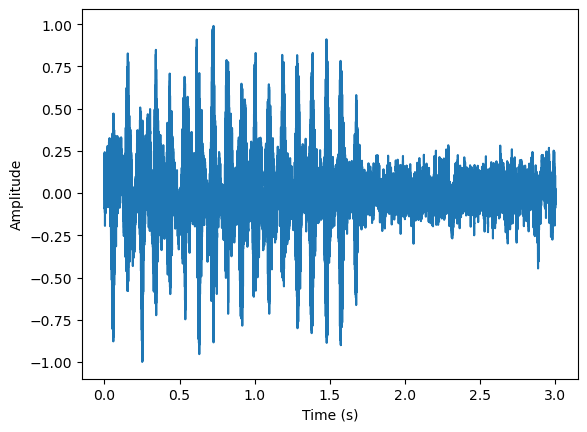

In [5]:
dataset = AudioDataset(file_list, device=device)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

data, sampling_rates = next(iter(dataloader))
print(f"Data shape: {data.shape}")
print(f"Sample rate: {sampling_rates[0]} Hz")

num_samples = data.shape[-1]
times = np.linspace(0, num_samples / sampling_rates[0], num_samples)

plt.figure()
plt.plot(times, data[0].cpu().numpy().squeeze())
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

## Dimensionality Reduction using an autoencoder

### Define the autoencoder architecture

The autoencoder is a neural network that learns to compress the input data into a lower-dimensional representation and then reconstruct it back to the original input.
The implementation of the network here is symmetrical, but this is not a requirement.

In [ ]:
def form_network(
    input_size: int, hidden_sizes: list[int], output_size: int
) -> nn.Module:
    layers = []
    in_features = input_size
    for out_features in hidden_sizes:
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        in_features = out_features
    layers.append(nn.Linear(in_features, output_size))
    return nn.Sequential(*layers)


class Encoder(nn.Module):
    def __init__(
        self, input_size: int, hidden_sizes: list[int], latent_size: int
    ) -> None:
        super(Encoder, self).__init__()
        self.encoder = form_network(input_size, hidden_sizes, latent_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(
        self, output_size: int, hidden_sizes: list[int], latent_size: int
    ) -> None:
        super(Decoder, self).__init__()
        self.decoder = form_network(latent_size, reversed(hidden_sizes), output_size)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)


class AudioAutoencoder(nn.Module):
    def __init__(self, input_size: int, hidden_sizes: list[int], latent_size: int):
        super(AudioAutoencoder, self).__init__()

        self.encoder = Encoder(input_size, hidden_sizes, latent_size)
        self.decoder = Decoder(input_size, hidden_sizes, latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        z = self.encoder(x)
        return self.decoder(z), z


def init_weights(m: nn.Module) -> None:
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

### Initialize the autoencoder

In this step, we instantiate the autoencoder model and initialize its weights.
We also define the loss function (mean squared error, MSE) and the optimizer (AdamW).

In [ ]:
autoencoder = AudioAutoencoder(
    input_size=num_samples,
    hidden_sizes=[4096, 2048, 1024, 512, 256, 128, 64, 32],
    latent_size=16,
)
autoencoder.apply(init_weights)  # Xavier initialization
print(autoencoder)
criterion = nn.MSELoss()
optimizer = optim.AdamW(autoencoder.parameters(), lr=0.0001)

AudioAutoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=66150, out_features=4096, bias=True)
      (1): ReLU()
      (2): Linear(in_features=4096, out_features=2048, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=512, bias=True)
      (7): ReLU()
      (8): Linear(in_features=512, out_features=256, bias=True)
      (9): ReLU()
      (10): Linear(in_features=256, out_features=128, bias=True)
      (11): ReLU()
      (12): Linear(in_features=128, out_features=64, bias=True)
      (13): ReLU()
      (14): Linear(in_features=64, out_features=32, bias=True)
      (15): ReLU()
      (16): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
  

### Train the autoencoder

The autoencoder is trained by training the network on mini-batches of data.
The training loop consists of the following steps:
1. Forward pass: The input data is passed through the autoencoder to obtain the output.
2. Compute the loss: The MSE loss is computed between the output and the input.
3. Backward pass: The gradients of the loss with respect to the weights are computed.
4. Update the weights: The optimizer updates the weights of the network using the gradients.
5. Repeat steps 1-4 for a set number of *epochs*.

The best model corresponds to the one with the lowest loss and is saved for future use.

In [ ]:
autoencoder = autoencoder.to(device)
criterion = criterion.to(device)

num_epochs = 10

best_loss = torch.inf
for epoch in range(num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")

    for x, _ in pbar:
        x_r, z = autoencoder(x)
        loss = criterion(x_r, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({"MSE": loss.item()})

    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(autoencoder.state_dict(), "best_model.pth")

Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/36 [00:00<?, ?it/s]

### Retrieve best autoencoder model

With training complete, we can now load the best model and use it to encode the data.
The model is placed in `eval` mode for inference (i.e., only the forward pass is performed).

In [ ]:
autoencoder.load_state_dict(torch.load(dataset_path.parent / "best_model.pth"))
autoencoder.eval()

AudioAutoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=66150, out_features=4096, bias=True)
      (1): ReLU()
      (2): Linear(in_features=4096, out_features=2048, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=1024, bias=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=512, bias=True)
      (7): ReLU()
      (8): Linear(in_features=512, out_features=256, bias=True)
      (9): ReLU()
      (10): Linear(in_features=256, out_features=128, bias=True)
      (11): ReLU()
      (12): Linear(in_features=128, out_features=64, bias=True)
      (13): ReLU()
      (14): Linear(in_features=64, out_features=32, bias=True)
      (15): ReLU()
      (16): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
  

### Perform inference on the data

The autoencoder is used to encode the data into a lower-dimensional representation.
Here we use the `dataloader` to iterate through the mini-batches of data and encode them using the autoencoder.

In [ ]:
latent_data = []
for x, _ in dataloader:
    _, z = autoencoder(x)
    latent_data.append(z.detach().cpu())

latent_data = torch.concatenate(latent_data, axis=0).numpy()

(9107, 16)


### Visualize the encoded data

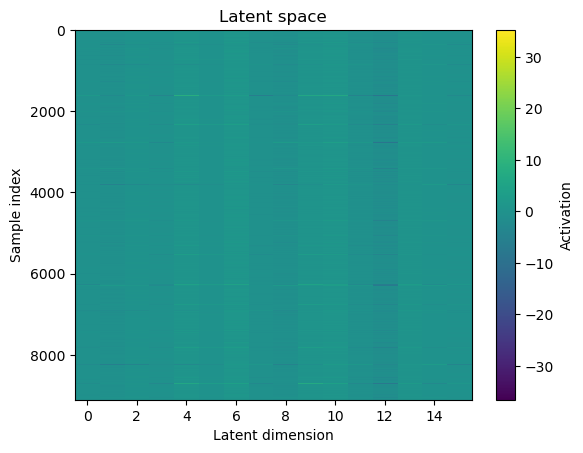

In [21]:
plt.figure()
plt.imshow(latent_data, aspect="auto", interpolation="none")
plt.xlabel("Latent dimension")
plt.ylabel("Sample index")
cbar = plt.colorbar()
cbar.set_label("Activation")
plt.title("Latent space")
plt.show()

### Visualize the original data and reconstructed data

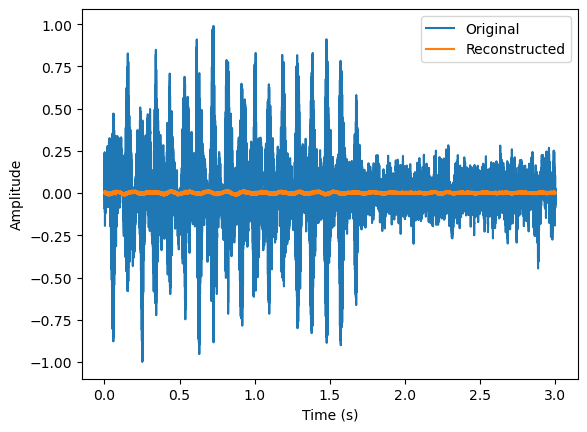

In [41]:
x = data[0]
x_r = autoencoder(x)[0].detach().cpu().numpy()

plt.figure()
plt.plot(times, x.cpu().numpy(), label="Original")
plt.plot(times, x_r, label="Reconstructed")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()